The final progect

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from time import sleep

import cv2
import torch
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow


In [3]:
# Download the YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

TENSOR_CLASSES = {
  0: "person",
  1: "bicycle",
  2: "car",
  3: "motorcycle",
  4: "airplane",
  5: "bus",
  6: "train",
  7: "truck",
  8: "boat",
}



/usr/local/lib/python3.9/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: YOLOv5 requirement "gitpython>=3.1.30" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 4.

  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [4]:
class CarNotFound(RuntimeError):
  pass

class CarEntity:

  def __init__(self, x, y, width, height, cls, accuracy):
    self.x = x
    self.y = y
    self.width = width
    self.height = height
    # class of car
    self.cls = cls
    # detection accuracy
    self.accuracy = accuracy


TENSOR_CLASSES_ENABLE = [2, 5, 6, 7]

def cars_detect(img, accuracy_threshold=0.5)->list[CarEntity]:
    # Using the model to detect cars
    objs = model(img, size=640)
    ret = []
    for det in objs.pred[0]:
        # Class of object and accuracy
        cls = det[-1]
        accuracy = det[-2]
        # adding result
        if accuracy > accuracy_threshold and cls in TENSOR_CLASSES_ENABLE:
            # print(det)
            x1, y1, x2, y2 = det[:4].numpy().astype(np.int32)
            ret.append(CarEntity(x1, y1, x2-x1, y2-y1, cls, accuracy))
    if len(ret) == 0:
      raise CarNotFound('Not found')
    else:
      return ret
    

def car_draw_rectangle_and_text(img, car_entity:CarEntity):
  # drawing rectangles where the car is found 
  # and displaying text information about the car
  
  x2 = car_entity.x + car_entity.width
  y2 = car_entity.y + car_entity.height
  cv2.rectangle(img, (car_entity.x, car_entity.y), (x2, y2), (0, 0, 255), 2)

  # print text
  text = '{}: {:.2f}'.format(TENSOR_CLASSES[int(car_entity.cls)], car_entity.accuracy)

  org = (car_entity.x + 5, car_entity.y + 20)
  font = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 0.5
  color = (0, 0, 255)
  thickness = 2
  cv2.putText(img, text, org, font, font_scale, color, thickness)
  return img



In [5]:
def plate_detect(img):
    # download the Haar cascade to detect license plates
    PATH_CASCADE = '/content/drive/MyDrive/python/Colab Notebooks/courses/rd/cv/final/data/car_plate_cascade.xml'
    car_plate_cascade = cv2.CascadeClassifier(PATH_CASCADE)
    # Convert the image to black
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Using the Haar cascade to detect license plates in the image
    car_plates = car_plate_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    return car_plates

def plate_draw_rectangles(img, plates, offset=(0, 0)):
  # drawing rectangles around license plates
  for (x, y, w, h) in plates:
    x = x + offset[0]
    y = y + offset[1]
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
  return img


In [33]:

def get_angles_of_corner(contour):
    contour = contour.reshape((4, 2))
    sorted_y = contour[np.argsort(contour[:, 1])]
    ups = sorted_y[0:2]
    bottoms = sorted_y[2:4]
    if ups[0][0] < ups[0][1]:
        top_left = ups[0]
        top_right = ups[1]
    else:
        top_left = ups[1]
        top_right = ups[0]
    if bottoms[0][0] < bottoms[0][1]:
        bottom_left = bottoms[0]
        bottom_right = bottoms[1]
    else:
        bottom_left = bottoms[1]
        bottom_right = bottoms[0]
    # res = [top_left, top_right, bottom_right, bottom_left]
    return [top_left, top_right, bottom_right, bottom_left]


def plate_transform(image):
    height, width = image.shape[:2]
    # cut border
    image = image[5:height - 5, 5:width - 5]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Filter noise using a Gaussian filter
    gray = cv2.GaussianBlur(gray, (7, 7), 9)

    # Filter out noise using a Harris filter
    dst = cv2.cornerHarris(gray, 6, 3, 0.04)
    dst = cv2.dilate(dst, None)
    ret, dst = cv2.threshold(dst, 0.01 * dst.max(), 255, 0)
    dst = np.uint8(dst)

    # Find contours in the image
    contours, hierarchy = cv2.findContours(dst, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area and approximate it to four corners
    approx_contours = []
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.05 * cv2.arcLength(contour, True), True)
        if len(approx) == 4:
            approx_contours.append(approx)

    # Choose the contour with the largest area
    max_area = 0
    for contour in approx_contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            best_contour = contour
    
    # get angles
    angles = get_angles_of_corner(best_contour)

    # transform the plate
    h, w = image.shape[:2]
    angles = np.array(angles, dtype=np.float32)
    # Let's determine the endpoints of the rectangle to which the image will be transformed
    angles_dst = np.array([(0, 0), (w - 1, 0), (w - 1, h - 1), (0, h - 1)], dtype=np.float32)
    # get the transformation matrix
    transform_matrix = cv2.getPerspectiveTransform(angles, angles_dst)
    # Let's convert the image
    transformed_image = cv2.warpPerspective(image, transform_matrix, (w, h))

    return transformed_image


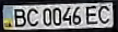

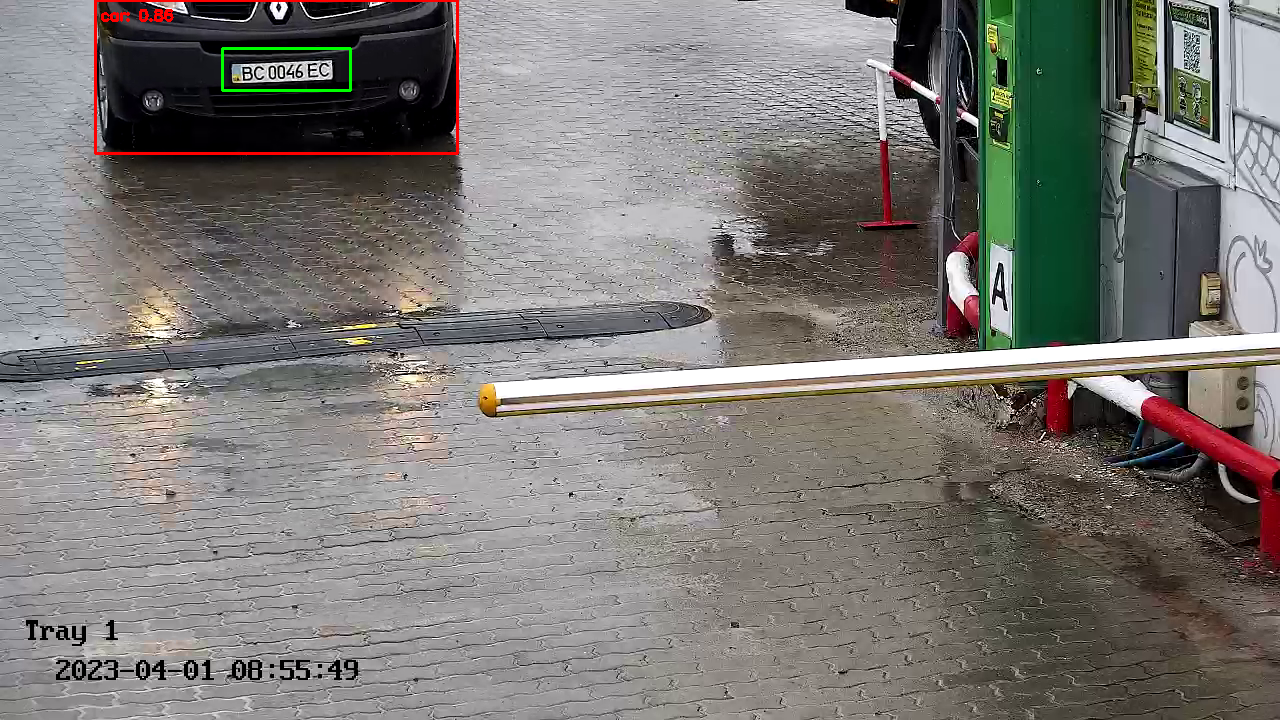

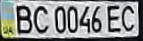

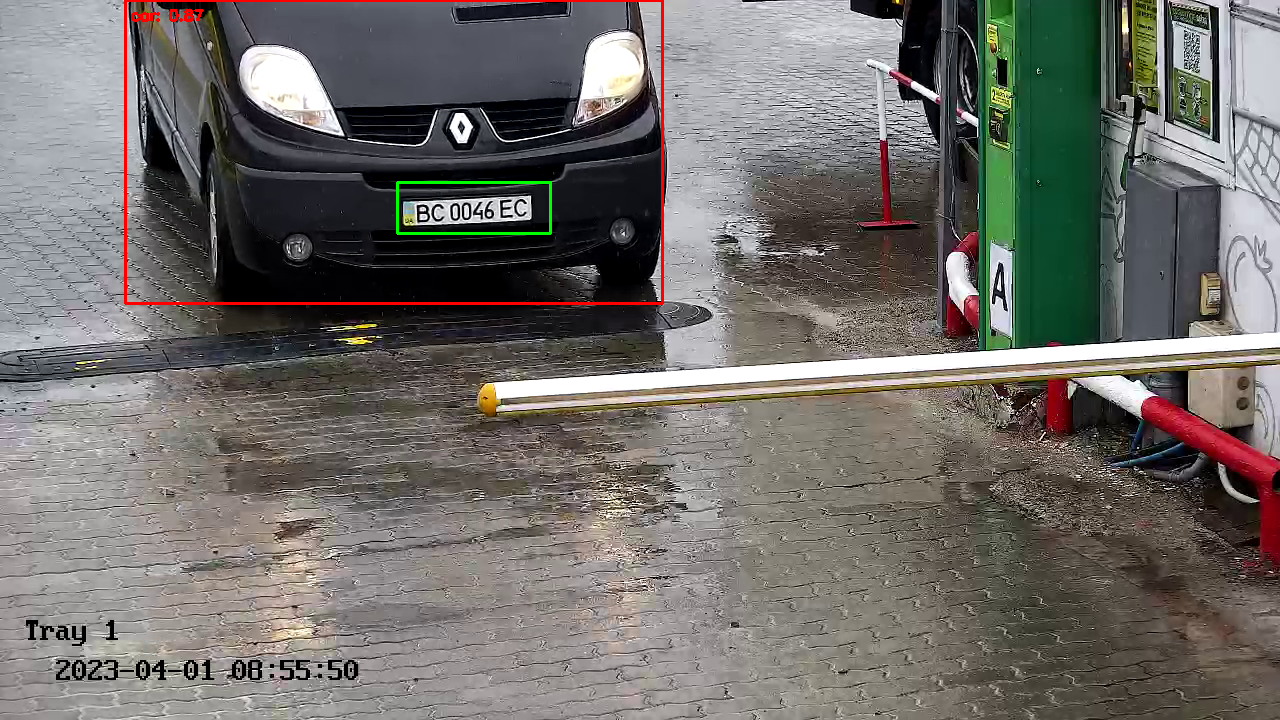

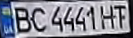

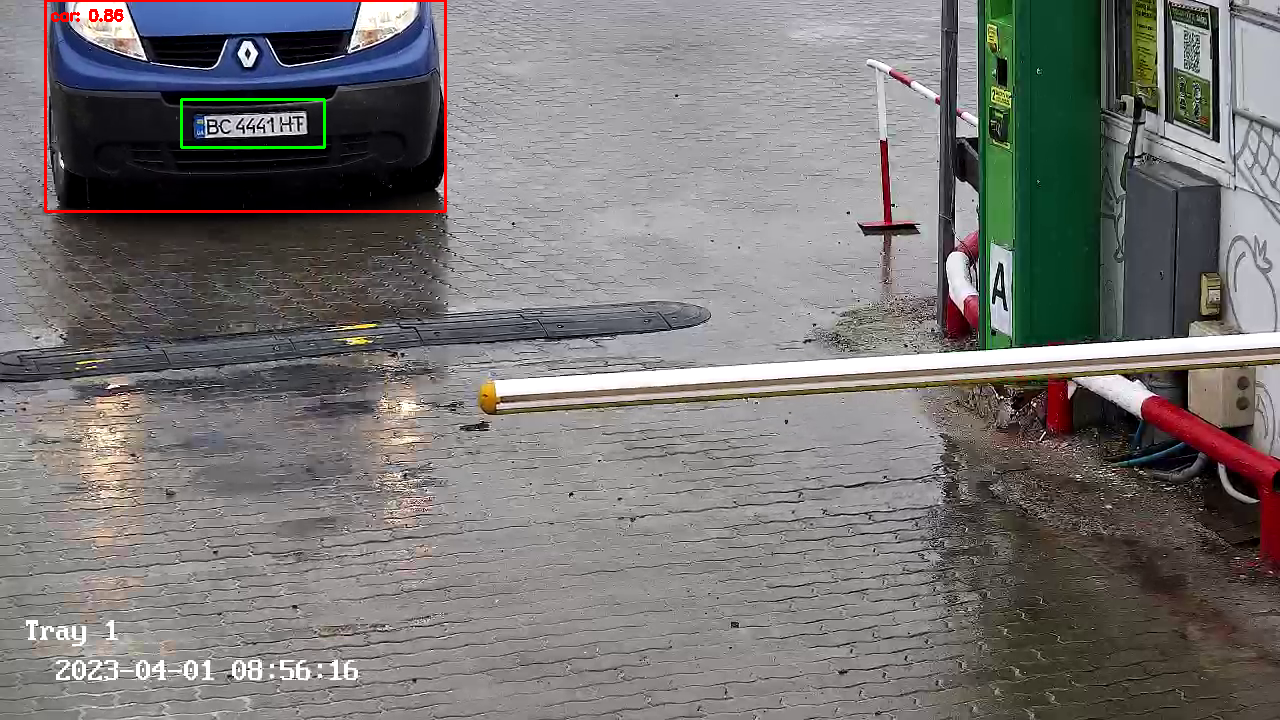

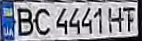

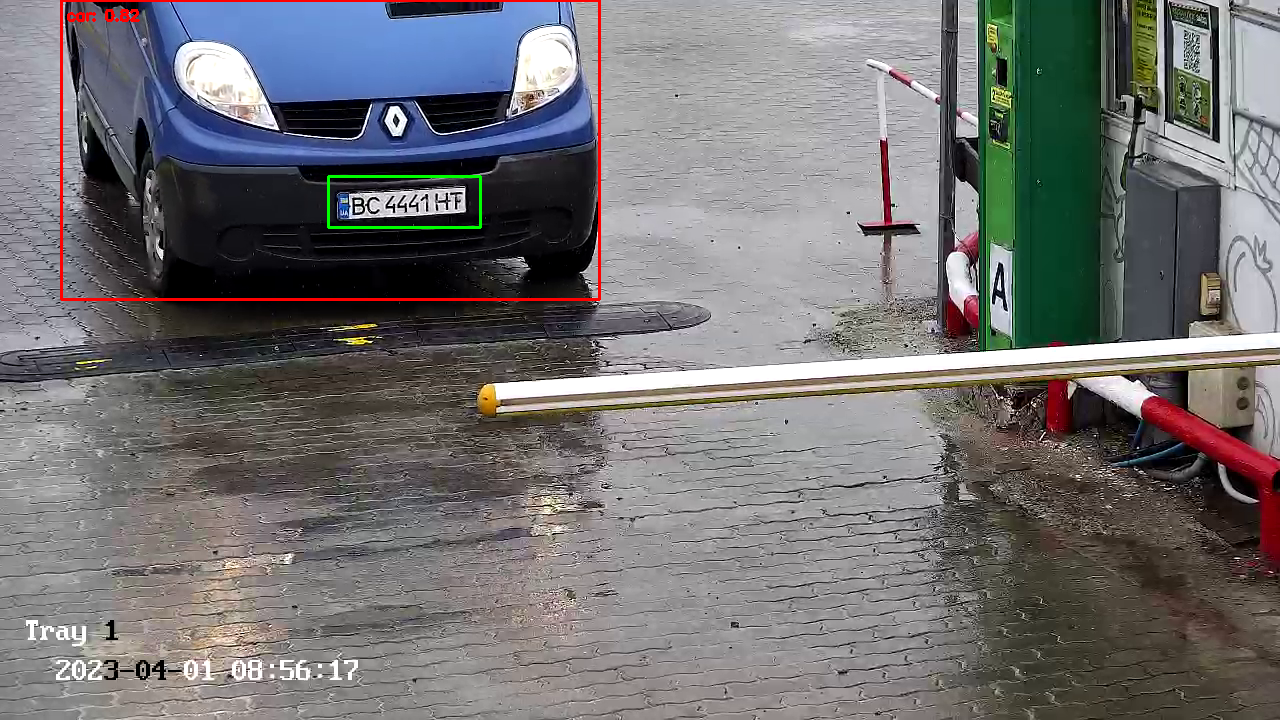

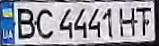

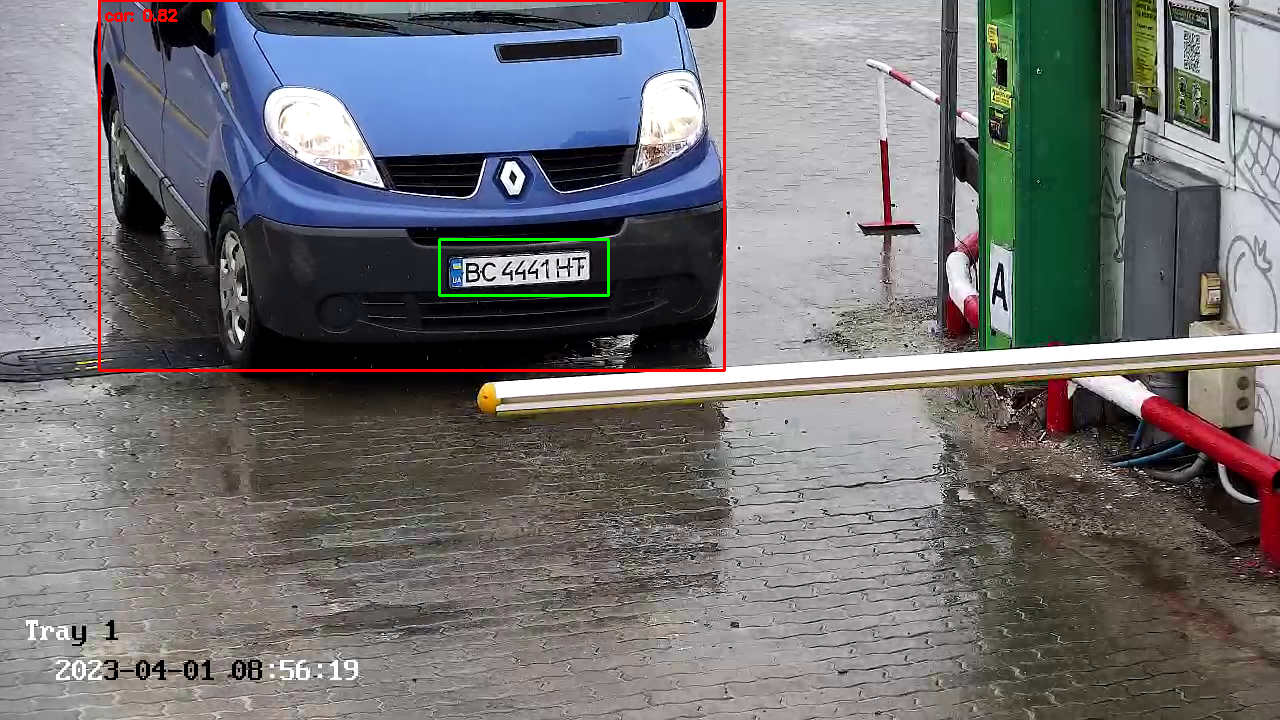

In [34]:
# camera initialization, we can use a file or an rtsp stream
PATH_OF_VIDEO = '/content/drive/MyDrive/python/Colab Notebooks/courses/rd/cv/final/data/video_2.mp4'
cap = cv2.VideoCapture(PATH_OF_VIDEO)

i = 0
while True:
  # get a image from the camera as frame
  ret, frame = cap.read()

  i += 1
  # break if the video too long
  if i > 2000:
    break
  # processing every 30th frame
  if (i % 30) == 0:
    try:
      # looking for a car, if the car is not found, the process is ignored 
      cars_entity = cars_detect(frame)
      # license plate search for each car
      for car_entity in cars_entity:
        if(car_entity.accuracy > 0.80):
          frame = car_draw_rectangle_and_text(frame, car_entity)
          x, y, w, h = car_entity.x, car_entity.y, car_entity.width, car_entity.height
          car_img = frame[y:y + h, x:x + w].copy()
          car_plates = plate_detect(car_img)
          frame = plate_draw_rectangles(frame, car_plates, (x, y))
          for (x, y, w, h) in car_plates:
            plate_img = car_img[y:y + h, x:x + w].copy()
            plate_transformed = plate_transform(plate_img)
            cv2_imshow(plate_transformed)
          cv2_imshow(frame)
    except CarNotFound:
      pass
    # sleep(0.01)

cap.release()
